In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
from load_5hot import load
from onehot_tostring import convert_to_nucs, show_noise
from keras import layers
from keras import callbacks
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv1D, Add, Reshape
from keras.layers import AveragePooling2D, UpSampling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K
from keras.layers.core import Lambda
from keras.models import Model
import matplotlib.pyplot as plt
import datetime
from keras.activations import softmax

K.set_image_data_format('channels_last')
print('Done')

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Done


In [3]:
[X_train,Y_train,X_test,Y_test,X_val,Y_val] = load("blast_tab_1hit.out")

Loading Data...
101886 sequences were uploaded

Maximum sequence length in is 308
Maximum sequence length out is 308

Converting to one-hot...
Done
Converting to one-hot...
Done
Converting to one-hot...
Done


In [4]:
m = X_train.shape[0]
print("There are " + str(m) + " training examples")
print("There are " + str(X_val.shape[0]) + " validation examples")
print("There are " + str(X_test.shape[0]) + " testing examples")
print("There are " + str(X_train.shape[1]) + " classes: A, C, G, T, -")
max_length = max(X_train.shape[2],X_test.shape[2])
print("The longest sequence is " + str(max_length) + " nucleotides long")
print("X_train shape is:")
print(X_train.shape)

There are 77510 training examples
There are 12269 validation examples
There are 12107 testing examples
There are 5 classes: A, C, G, T, -
The longest sequence is 308 nucleotides long
X_train shape is:
(77510, 5, 308, 1)


In [5]:
# Visualize data sets to ensure they appear as anticipated
def display_example_sequences(X,Y,n):
    for sample in range(n):
        samp_n_X = convert_to_nucs(X[sample,:,:,0])
        samp_n_Y = convert_to_nucs(Y[sample,:,:,0])
        print(samp_n_X + ', ' + samp_n_Y + '\n')

    print('')
    
n_examples = 3
print('\nTraining Examples:\n')
display_example_sequences(X_train,Y_train,n_examples)
print('\nValidation Examples:\n')
display_example_sequences(X_val,Y_val,n_examples)
print('\nTesting Examples:\n')
display_example_sequences(X_test,Y_test,n_examples)


Training Examples:

ACGGAGGGTGCGAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGCTTGGTAAGTCAGGGGTGAAAGCCCGCGGCTCAACCGCGGAATTGCCTTTGATACTGC-CGAGCTAGAGTCCGGGAGAGGGTAGTGGAATTCCAGGTGTAGGAGTGAAATCCGTAGAGATCTGGAGGAACATCAGTGGCGAAGGCGACTACCTGGACCGGTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAG--------------------------------------------------------, ACGGAGGGTGCAAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGTTATGTAAGTCAGGGGTGAAAGCCCACGGCTCAACCGTGGAACTGCCCTTGATACTGCACGA-CTCGAATCCGGGAGAGGGTGGCGGAATTCCAGGTGTAGGAGTGAAATCCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGGCCACCTGGACCGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAG--------------------------------------------------------

ACAGAGGGGGCAAGCGTTGTCCGGAGTTACTGGGCGTAAAGGGCGCGCAGGCGGTGGGCTGCGTCGGCGCTGAAAGCGCCCCGCTTAACGGGGCGAGGCGCGCCGATACGAGTCCACTCGAGGCAAGCAGAGGGTGGCGGAATTCCGGGTGGAGTGGTGAAATGCGTAGAGATCCGGAGGAACGCCGGTGGGGAAGCCGGCCACCTGGGCTTGACCTGACGCTGCGGCGCGACAGCGTGGGGAGCAAACCG---------------------------------------------------------, ACAGAGGGGGCAAGCGTTGTCCGGAGTTACTGGGCGTAAAGGGCGCGCA

In [6]:
print('Permuting training samples...')
np.random.seed(0)
rand_perm = np.random.rand(m).argsort()
np.take(X_train,rand_perm,axis=0,out=X_train)
print("finished X")
np.take(Y_train,rand_perm,axis=0,out=Y_train)
print("finished Y")

Permuting training samples...
finished X
finished Y


In [9]:
ngf = 16
input_nc = 1
output_nc = 1
n_blocks_gen = 9

def softMaxAxis1(x):
    return softmax(x,axis=1)

# started from: https://blog.sicara.com/keras-generative-adversarial-networks-image-deblurring-45e3ab6977b5
def Model_1(input_shape):
    """Build generator architecture."""
    # Current version : ResNet block
    X_input = Input(input_shape)

    X = Conv2D(128, (4, 7), strides = (1, 1), padding = 'same', name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(64, (1, 7), strides = (1, 1), padding = 'same', name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(64, (1, 7), strides = (1, 1), padding = 'same', name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Dropout(0.3, name = 'dropout')(X)
   
    X = Conv2D(32, (1, 7), strides = (1, 1), padding = 'same', name = 'conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(1, (1, 1), strides = (1, 1), padding = 'same', name = 'conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Dense(1, activation = softMaxAxis1)(X)
    
    model = Model(inputs=X_input, outputs=X, name='Model_2')
    return model

In [10]:
myModel = Model_1((5,max_length,1))
print(myModel.summary())
print('Done!')
logging = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5, 308, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 5, 308, 128)       3712      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 5, 308, 128)       512       
_________________________________________________________________
activation_5 (Activation)    (None, 5, 308, 128)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 5, 308, 64)        57408     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 5, 308, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 5, 308, 64)        0         
__________

In [11]:
myModel.compile(optimizer="Adam", loss="mean_squared_error", metrics = ["accuracy"])
print('Done!')

Done!


In [12]:
# Understand baseline accuracy of if model output its own input
diffs = np.absolute(X_train-Y_train);
err = np.sum(diffs)/np.ma.size(X_train);
print("Baseline accuracy of Train if predicting output = input is " + str(1-err))

diffs = np.absolute(X_val-Y_val);
err = np.sum(diffs)/np.ma.size(X_val);
print("Baseline accuracy of Val if predicting output = input is " + str(1-err))

diffs = np.absolute(X_test-Y_test);
err = np.sum(diffs)/np.ma.size(X_test);
print("Baseline accuracy of Test if predicting output = input is " + str(1-err))

Baseline accuracy of Train if predicting output = input is 0.994588750173836
Baseline accuracy of Val if predicting output = input is 0.999137833394904
Baseline accuracy of Test if predicting output = input is 0.9990534616123119


In [14]:
class NBatchLogger(callbacks.Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.losses = []
        self.accs = []

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        if self.step % self.display == 0:
            loss = logs.get('loss')
            acc = logs.get('acc')
            self.losses.append(loss)
            self.accs.append(acc)
            print('\nstep {}: loss = {}, acc = {}'.format(self.step, loss, acc))

            
out_batch = NBatchLogger(display=500)
filepath="./convWeights/5hot-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)
history = myModel.fit(x = X_train, y = Y_train, epochs = 15, validation_data = (X_val, Y_val), batch_size = 20, callbacks = [checkpoint, out_batch], verbose = 1)

loss_and_acc = myModel.evaluate(X_test, Y_test)
print(loss_and_acc)

currtime = datetime.datetime.now()
fname = "./convWeights/" + currtime.strftime("%m%d-%H%M") + "_5hot.hdf5"
print(fname)
myModel.save_weights(fname)
logging.append(out_batch)
histfname = "./trainHistoryDict_" + currtime.strftime("%m%d-%H%M") + "_5hot"
with open(histfname, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Train on 77510 samples, validate on 12269 samples
Epoch 1/15
10000/77510 [==>...........................] - ETA: 54:11 - loss: 0.0119 - acc: 0.9966
step 500: loss = 0.01035445649176836, acc = 0.9970779418945312
20000/77510 [======>.......................] - ETA: 45:09 - loss: 0.0107 - acc: 0.9973
step 1000: loss = 0.00853984709829092, acc = 0.9990260004997253
30000/77510 [==========>...................] - ETA: 37:00 - loss: 0.0102 - acc: 0.9976
step 1500: loss = 0.00830515380948782, acc = 0.9991558194160461
40000/77510 [==============>...............] - ETA: 30:04 - loss: 0.0099 - acc: 0.9978
step 2000: loss = 0.008366881869733334, acc = 0.9990584254264832
50000/77510 [==================>...........] - ETA: 22:44 - loss: 0.0097 - acc: 0.9979
step 2500: loss = 0.008152995258569717, acc = 0.9991558194160461
60000/77510 [======================>.......] - ETA: 15:09 - loss: 0.0096 - acc: 0.9980
step 3000: loss = 0.00808893796056509, acc = 0.9992856979370117
70000/77510 [===================

24880/77510 [========>.....................] - ETA: 40:34 - loss: 0.0085 - acc: 0.9988
step 24500: loss = 0.009958391077816486, acc = 0.9973052144050598
34880/77510 [============>.................] - ETA: 32:52 - loss: 0.0085 - acc: 0.9989
step 25000: loss = 0.007886302657425404, acc = 0.9994805455207825
44880/77510 [================>.............] - ETA: 25:09 - loss: 0.0085 - acc: 0.9989
step 25500: loss = 0.007531044073402882, acc = 0.9997727274894714
54880/77510 [====================>.........] - ETA: 17:26 - loss: 0.0085 - acc: 0.9989
step 26000: loss = 0.00782802328467369, acc = 0.9996103644371033
64880/77510 [========================>.....] - ETA: 9:44 - loss: 0.0085 - acc: 0.9989
step 26500: loss = 0.008515212684869766, acc = 0.9986688494682312
74880/77510 [===========================>..] - ETA: 2:01 - loss: 0.0085 - acc: 0.9989
step 27000: loss = 0.009202029556035995, acc = 0.9979870319366455
77510/77510 [==============================] - 3749s 48ms/step - loss: 0.0085 - acc: 

39760/77510 [==============>...............] - ETA: 29:15 - loss: 0.0084 - acc: 0.9990
step 48500: loss = 0.008407456800341606, acc = 0.9988636374473572
49760/77510 [==================>...........] - ETA: 21:29 - loss: 0.0084 - acc: 0.9990
step 49000: loss = 0.00808696262538433, acc = 0.9992856979370117
59760/77510 [======================>.......] - ETA: 13:45 - loss: 0.0084 - acc: 0.9990
step 49500: loss = 0.00985176581889391, acc = 0.9975973963737488
69760/77510 [==========================>...] - ETA: 6:00 - loss: 0.0084 - acc: 0.9990
step 50000: loss = 0.007729595061391592, acc = 0.9996753334999084
77510/77510 [==============================] - 3766s 49ms/step - loss: 0.0084 - acc: 0.9990 - val_loss: 0.0076 - val_acc: 0.9998
Epoch 14/15
 2240/77510 [..............................] - ETA: 58:07 - loss: 0.0083 - acc: 0.9990
step 50500: loss = 0.008833704516291618, acc = 0.9984740018844604
12240/77510 [===>..........................] - ETA: 50:25 - loss: 0.0084 - acc: 0.9990
step 51000

In [97]:
histfname = "./trainHistoryDict_" + "0603-0412" + "_5hot"
history = pickle.load(open(histfname, "rb" ))

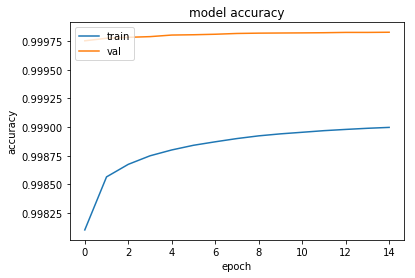

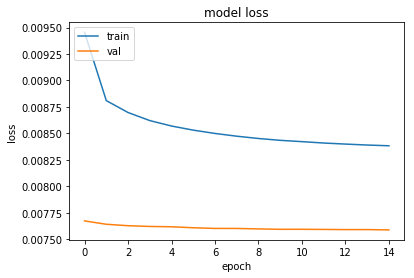

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [17]:
preds = myModel.predict(x = X_test)

In [18]:
# Show whole sequence
for n in range(100):
    print("Sample number " + str(n+1))
    samp_n_pred = preds[n,:,:,0]
    samp_n_in = X_test[n,:,:,0]
    samp_n_true = Y_test[n,:,:,0]

    samp_n_pred = convert_to_nucs(samp_n_pred)
    samp_n_true = convert_to_nucs(samp_n_true)
    samp_n_in = convert_to_nucs(samp_n_in)
    noisy = show_noise(samp_n_pred, samp_n_true, samp_n_in)

    print('Predicted:')
    print('Denoised:')
    print('Noisy:')
    print('Noise locations:\n')

    stt = 0
    stp = 100
    while(stp < len(noisy)):
        print(samp_n_pred[stt:stp])
        print(samp_n_true[stt:stp])
        print(samp_n_in[stt:stp])
        print(noisy[stt:stp])
        print('')
        stt = stp
        stp = stt+100



Sample number 1
Predicted:
Denoised:
Noisy:
Noise locations:

ACGGAGGGCGCGAGCGTTACCCGGATTCACTGGGCGTAAAGGGCGTGTAGGCGGCCTGGGGCGTCCCATGTGAAAGACCACGGCTCAACCGTGGGGGAGC
ACGGAGGGCGCGAGCGTTACCCGGATTCACTGGGCGTAAAGGGCGTGTAGGCGGCCTGGGGCGTCCCATGTGAAAGACCACGGCTCAACCGTGGGGGAGC
ACGGAGGGCGCGAGCGTTACCCGGATTCACTGGGCGTAAAGGGCGTGTAGGCGGCCTGGGGCGTCCCATGTGAAAGACCACGGCTCAACCGTGGGGGAGC
----------------------------------------------------------------------------------------------------

GTGGGATACGCTCAGGCTAGACGGTGGGAGAGGGTGGTGGAATTCCCGGAGTAGCGGTGAAATGCGCAGATACCGGGAGGAACGCCGATGGCGAAGGCAG
GTGGGATACGCTCAGGCTAGACGGTGGGAGAGGGTGGTGGAATTCCCGGAGTAGCGGTGAAATGCGCAGATACCGGGAGGAACGCCGATGGCGAAGGCAG
GTGGGATACGCTCAGGCTAGACGGTGGGAGAGGGTGGTGGAATTCCCGGAGTAGCGGTGAAATGCGCAGATACCGGGAGGAACGCCGATGGCGAAGGCAG
----------------------------------------------------------------------------------------------------

CCACCTGGTCCACCCGTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACCG-------------------------------------------------
CCACCTGGTCCACCCGTGACGCTGAGG

Predicted:
Denoised:
Noisy:
Noise locations:

ACGTATGTCACAAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGTGGTTATGTAAGTCTGATGTGAAAATGCAGGGCTCAACTCTGTATTGCG
ACGTATGTCACAAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGTGGTTATGTAAGTCTGATGTGAAAATGCAGGGCTCAACTCTGTATTGCG
ACGTATGTCACAAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGTGGTTATGTAAGTCTGATGTGAAAATGCAGGGCTCAACTCTGTATTGCG
----------------------------------------------------------------------------------------------------

TTGGAAACTGTGTAACTAGAGTACTGGAGAGGTAAGCGGAACTACAAGTGTAGAGGTGAAATTCGTAGATATTTGTAGGAATGCCGATGGGGAAGCCAGC
TTGGAAACTGTGTAACTAGAGTACTGGAGAGGTAAGCGGAACTACAAGTGTAGAGGTGAAATTCGTAGATATTTGTAGGAATGCCGATGGGGAAGCCAGC
TTGGAAACTGTGTAACTAGAGTACTGGAGAGGTAAGCGGAACTACAAGTGTAGAGGTGAAATTCGTAGATATTTGTAGGAATGCCGATGGGGAAGCCAGC
----------------------------------------------------------------------------------------------------

TTACTAGACAGATACTGACGCTGAAGCGCGAAAGCGTGGGTAGCAAACAG--------------------------------------------------
TTACTAGACAGATACTGACGCTGAAGCGCGAAAGCGTGGGTAG

In [22]:
def calc_acc(y_predicted, y_true):
    noiseless = 0
    num_examples = y_predicted.shape[0]
    for n in range(num_examples):
        samp_n_pred = convert_to_nucs(y_predicted[n,:,:,0])
        samp_n_true = convert_to_nucs(y_true[n,:,:,0])
        
        if samp_n_pred == samp_n_true:
            noiseless = noiseless + 1
            
    return noiseless/num_examples
            
print("Accuracy of input = output is: " + str(calc_acc(X_test,Y_test)))
print("Accuracy of model output is: " + str(calc_acc(preds,Y_test)))
    

Accuracy of input = output is: 0.8755265548856034
Accuracy of model output is: 0.9648137441149748


In [95]:
myModel.load_weights("./convWeights/0603-0412_5hot.hdf5")